### Mike's Exploration of the ADH data...

This builds off of Spencer's replication. It cuts the data in a way that we can plot and understand what is going on...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"
# This is if I want to output the figure

This reads in the ADH dataset and then adds a constant.

In [2]:
df = pd.read_stata("workfile_china.dta")
df["const"] = 1

Then lets check out the var names.

In [3]:
var_names  = pd.DataFrame(df.columns)

var_names.to_excel("var_names.xlsx") # If you want to see what they are (like 200) this 
                                     # this is one way to do it...

regions = list(filter(lambda x: x.startswith("reg"), df.columns))
                                    # Spencer's way to figure out regional dummies.

df["dm_IPW"] = df.d_tradeusch_pw / df.d_tradeusch_pw.mean()
                                    # This is a normalization I'm going to explore
                                    # The one thing about this is it is off the change, not the level...
                                    # This, thus, could be zero in the model.

This last bit takes the IPW measure and then divides by the mean. The idea here is to get things out of dollars and into a unit that we can better understand. 

In [22]:
df.set_index("yr").loc[2000].d_tradeusch_pw.median()



1.935425241763572

This then check the population, it says in 1990 there were 246 million and this check with what google is doing. Then below is jsut reports some summary statistics behind the average growth in wages. On average, it grew by 8 log points 

In [52]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

---
### Wage results...

I first want to plot this and cut it by the time period. ADH main results stack two time periods 90s and 2000s. The 2000s correspond with the big rise in Chinese trade; the 1990s is far less dramatic. I want to explore this issue in the context of the wage regressions. 

#### The plot test

Lets simply plot the change in IPW vs. the log difference of weekly wages by commute zone. And break it out by time period.

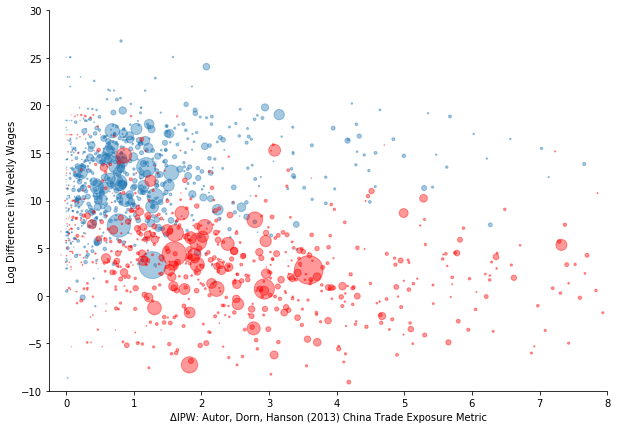

In [98]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

ax.scatter(df.set_index("yr").loc[int(year)].d_tradeusch_pw, #X variables
           df.set_index("yr").loc[int(year)].d_avg_lnwkwage,     # y variables 
            s = 0.00005*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].d_tradeusch_pw, #X variables
           df.set_index("yr").loc[int(year)].d_avg_lnwkwage,     # y variables 
           s = 0.00005*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Log Difference in Weekly Wages") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-10,30)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

This is quite interesting. What do I see:

- First you see how there is far more variation in trade exposure for the 2000s (red) periods vs. the 90s (blue). China came in and **fundamentally altered a commute zones exposure to trade by large amounts** 


- If you eye-ball this enough, for the 90s, **there is essentially zero correlation between wage growth and trade exposure during this time period.** If anything, it is slightly positive. But overall, it is mostly compressed between 0 and 1000 with lots of wage variation.


- If you look at the 2000s (red), two things are going on. First, wage growth is lower overall (shorter time period?) Second, there is (what I see) **a "hockey stick" pattern between wage growth and trade exposure**. 

In [128]:
year = "2000"

reg_df = df.set_index("yr").loc[int(year)]
#reg_df = df

rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]


#reg_df = df.set_index("yr").loc[2000]


res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions + ["d_tradeusch_pw"]],
                   None, None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.4052
Estimator:                        OLS   Adj. R-squared:                 0.3926
No. Observations:                 722   F-statistic:                    243.75
Date:                Thu, Mar 15 2018   P-value (F-stat)                0.0000
Time:                        17:40:26   Distribution:                 chi2(15)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.5702     10.116     0.1552     0.8766     -18.256      21.397
l_shind_manuf_cbp    -0.

In [127]:
#year = "2000"

reg_df = df.set_index("yr").loc[int(year)]

reg_df = df

rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource",
          "t2"]

#reg_df = df.set_index("yr").loc[2000]

res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.5603
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5553
No. Observations:                1444   F-statistic:                    978.37
Date:                Thu, Mar 15 2018   P-value (F-stat)                0.0000
Time:                        17:22:41   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 17.985     4.8390     3.7167     0.0002      8.5008      27.469
l_shind_manuf_cbp     0.

In [51]:
reg_df.head()

,czone,statefip,city,t2,timepwt48,reg_midatl,reg_encen,reg_wncen,reg_satl,reg_escen,...,d_tradeuschlw_pw,d_tradeotchlw_pw_lag,d_tradeuschce_pw,d_tradeotchce_pw_lag,d_tradeusce_pw,d_tradeotce_pw_lag,d_tradeushi_pw,d_tradeothi_pw_lag,const,dm_IPW
yr,,,,,,,,,,,,,,,,,,,,,
1990,100.0,47,undefined,0,0.002114,0,0,0,0,1,...,5.745085,2.437189,11.723440,2.363754,6.429653,0.084927,30.744575,8.696790,1,2.778006
1990,200.0,47,undefined,0,0.000732,0,0,0,0,1,...,3.139381,3.033377,5.698626,2.847327,2.668147,0.049593,16.205678,3.316682,1,1.590296
1990,301.0,47,undefined,0,0.000261,0,0,0,0,1,...,2.656860,0.798065,6.746723,0.739753,4.684127,0.018845,18.276355,0.465902,1,1.082383
1990,302.0,47,undefined,0,0.002569,0,0,0,0,1,...,1.473966,1.593264,2.381899,1.490031,1.303590,0.037893,10.231065,1.610382,1,0.565861
1990,401.0,37,undefined,0,0.001714,0,0,0,1,0,...,1.345073,1.427622,2.497527,1.393612,1.481442,0.059779,9.214262,14.122767,1,0.533208


---

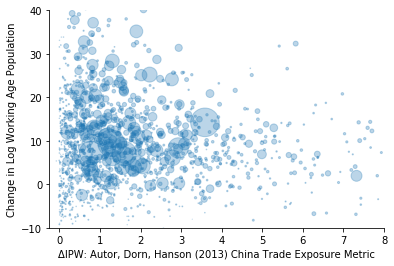

In [42]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_popworkage,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Working Age Population") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-10,40)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_pop_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

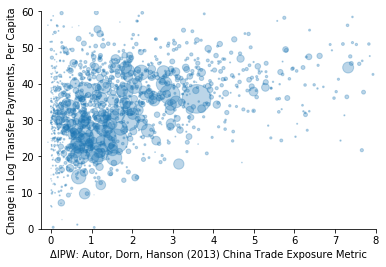

In [43]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_trans_totindiv_pc,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Transfer Payments, Per Capita") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-0,60)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_trans_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

**This is the Houshold income measure**

In [ ]:
fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"

fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, relchg_avg_hhincsum_pc_pw,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Log Change in Average Weekly Wages") 
ax.set_xlabel("IPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-20,35)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

In [46]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource", "t2"]


res_first = IV2SLS(df.lnchg_popworkage, df[["const"] + rhs_var+ regions+ ["d_tradeusch_pw"]], 
                   None, None, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4250
Estimator:                        OLS   Adj. R-squared:                 0.4185
No. Observations:                1444   F-statistic:                    1067.3
Date:                Thu, Mar 15 2018   P-value (F-stat)                0.0000
Time:                        14:16:15   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.1659     5.4564     0.2137     0.8308     -9.5284      11.860
l_shind_manuf_cbp    -0.

In [28]:
res_first = IV2SLS(df.lnchg_popworkage, df[["const"]+ rhs_var + regions], 
                   df.d_tradeusch_pw, df.d_tradeotch_pw_lag, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4234
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4169
No. Observations:                1444   F-statistic:                    1061.5
Date:                Sat, Mar 10 2018   P-value (F-stat)                0.0000
Time:                        08:48:41   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.2356     5.4644     0.2261     0.8211     -9.4745      11.946
l_shind_manuf_cbp    -0.

In [16]:
just1990 = df.set_index("yr").loc[1990]

res_first = IV2SLS(just1990.d_avg_lnwkwage, 
                   just1990[["const"]], 
                   just1990.dm_IPW, just1990.d_tradeotch_pw_lag,
                   weights = just1990["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.0008
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0006
No. Observations:                 722   F-statistic:                    0.0063
Date:                Thu, Mar 01 2018   P-value (F-stat)                0.9370
Time:                        16:17:57   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          11.866     0.3043     38.987     0.0000      11.269      12.462
dm_IPW         0.0136     0.1717     0.0791     0.93